<div align="right">
  December 17th, 2015
</div>
<div align="center">
<font size="6"><b>Muon in Jets Studies</b><br>
$hh\rightarrow \gamma \gamma bb$ <br> </font>
<br>
Michela Paganini, Yale University
</div>

In [1]:
import pandas as pd
import pandautils as pup
import numpy as np
from rootpy.vector import LorentzVector
from rootpy.plotting.style import get_style, set_style
import matplotlib.pyplot as plt
%matplotlib inline

/usr/local/lib/python2.7/site-packages/IPython/kernel/__init__.py:13: ShimWarning: The `IPython.kernel` package has been deprecated. You should import from ipykernel or jupyter_client instead.
  "You should import from ipykernel or jupyter_client instead.", ShimWarning)


In [2]:
# -- open a file to svae the names of the branches we are interested in (the ones containing Muons or Jets)
from rootpy.io import root_open
f = root_open("../MxAOD/Truth_11-30/user.mpaganin.mc15_13TeV.341175.A14NNPDF23LO_X350tohh_yybb.merge.DAOD_HIGG1D1.e3873_a766_a768_r6282_p2421.Truth_11-30_MxAOD.root/user.mpaganin.7141844._000001.MxAOD.root", "read")
t = f["CollectionTree"]
features = [key.GetName() for key in t.GetListOfBranches() if (('HGamMuonsAuxDyn' in key.GetName()) or ('HGamAntiKt4EMTopoJetsAuxDyn' in key.GetName()))]
f.Close()

False

In [3]:
# -- Open MxAODs and save them in df, only accessing interesting branches:
X350_df = pup.root2panda("../MxAOD/muons/muons/user.mpaganin.mc15_13TeV.341175.A14NNPDF23LO_X350tohh_yybb.merge.DAOD_HIGG1D1.e3873_a766_a768_r6282_p2421.muons_MxAOD.root/*", "CollectionTree",
                        branches = features) 
H300_df = pup.root2panda("../MxAOD/muons/muons/user.mpaganin.mc15_13TeV.341004.A14NNPDF23LO_H300_Xtohh_yybb.merge.DAOD_HIGG1D1.e3846_a766_a768_r6282_p2421.muons_MxAOD.root/*", "CollectionTree",
                        branches = features)
X275_df = pup.root2panda("../MxAOD/muons/muons/user.mpaganin.mc15_13TeV.341173.A14NNPDF23LO_X275tohh_yybb.merge.DAOD_HIGG1D1.e3873_a766_a768_r6282_p2421.muons_MxAOD.root/*", "CollectionTree",
                        branches = features)
X325_df = pup.root2panda("../MxAOD/muons/muons/user.mpaganin.mc15_13TeV.341174.A14NNPDF23LO_X325tohh_yybb.merge.DAOD_HIGG1D1.e3873_a766_a768_r6282_p2421.muons_MxAOD.root/*", "CollectionTree",
                        branches = features)
sm_df = pup.root2panda("../MxAOD/muons/muons/user.mpaganin.mc15_13TeV.341559.A14NNPDF23LO_sm_hh_yybb.merge.DAOD_HIGG1D1.e4038_s2608_s2183_r6765_r6282_p2421.muons_MxAOD.root/*", "CollectionTree",
                      branches = features)

In [4]:
# -- concatenate all resonances into one df
signal_df = pd.concat([X350_df,X325_df,H300_df,X275_df], ignore_index=True)

In [5]:
# -- list of 4 vectors of all jets
jet4vecs = pup.match_shape(np.asarray([(pt,eta,phi,m) for (pt,eta,phi,m) in zip(pup.flatten(signal_df['HGamAntiKt4EMTopoJetsAuxDyn.pt']), 
                                       pup.flatten(signal_df['HGamAntiKt4EMTopoJetsAuxDyn.eta']),
                                       pup.flatten(signal_df['HGamAntiKt4EMTopoJetsAuxDyn.phi']),
                                       pup.flatten(signal_df['HGamAntiKt4EMTopoJetsAuxDyn.m']))]), 
                signal_df['HGamAntiKt4EMTopoJetsAuxDyn.pt'])

In [38]:
# -- list of 4 vectors of all muons
muon4vecs = pup.match_shape(np.asarray([(pt,eta,phi,105.6583715) for (pt,eta,phi) in zip(pup.flatten(signal_df['HGamMuonsAuxDyn.pt']), 
                                       pup.flatten(signal_df['HGamMuonsAuxDyn.eta']),
                                       pup.flatten(signal_df['HGamMuonsAuxDyn.phi']))]), 
                signal_df['HGamMuonsAuxDyn.pt'])

In [39]:
# -- CUT: only consider muons with pt > 4 GeV
muon4vecs = [np.delete(muon4vecs[ev], np.where([muon4vecs[ev][muon][0] < 4000 for muon in xrange(len(muon4vecs[ev]))]), 0) for ev in xrange(len(muon4vecs))]

In [8]:
def deltaR(eta1, eta2, phi1, phi2):
    import math
    '''
    Definition:
    -----------
        Function that calculates DR between two objects given their etas and phis
    Args:
    -----
        eta1 = float, eta of first object
        eta2 = float, eta of second object
        phi1 = float, phi of first object
        phi2 = float, phi of second object
    Output:
    -------
        deltaR = float, distance between the two objects 
    '''
    DEta = abs(eta1-eta2)
    DPhi = math.acos(math.cos( abs( phi1-phi2 ) ) ) # hack to avoid |phi1-phi2| larger than 180 degrees
    return math.sqrt( pow(DEta,2) + pow(DPhi,2) ) 

In [9]:
# -- list of distances of all jets from all muons
dr = [
    [[deltaR(jet4vecs[ev][jet][1],muon4vecs[ev][muon][1],jet4vecs[ev][jet][2],muon4vecs[ev][muon][2])  
      
            for muon in xrange(len(muon4vecs[ev])) 
            if (len(muon4vecs[ev]) != 0)]
     
         for jet in xrange(len(jet4vecs[ev]))]
    for ev in xrange(len(jet4vecs)) ]
# -- considering all jets and all muons with pt > 4 GeV!

In [10]:
DRMIN = 0.4

### Correct all jets using muons with pt > 4 GeV

Save lists of: <br>
- 4 vectors of all jets, with corrections from all muons
- 4 vectors of all jets, with corrections from one muon (the closest one)
- 4 vectors of all jets, no correction
- 4 vectors of all muons in jet, for all jets
- 4 vector of closest muon in jet, for all jets
- number of muons in jet, for all jets

In [84]:
# -- define lists to save --> these will be lists of lists (event,jet structure)
corrected_jets_allmuons = []
corrected_jets_onemuon = []
original_jets = []
muons_corrections = []
onemuon_correction = []
NmuonsInJ = []

# -- loop thru events
for ev in xrange(len(dr)):
    # -- define event-level sub-lists to then append to the lists defined above
    corrected_jets_allmuons_per_event = []
    corrected_jets_onemuon_per_event = []
    original_jets_per_event = []
    NmuonsInJ_per_event = []
    muons_corrections_per_event = []
    onemuon_correction_per_event = []
    
    # -- loop thru jets
    for jet in xrange(len(dr[ev])):
        pjet = LorentzVector() # instantiate 4 vector of the jet
        pjet.SetPtEtaPhiM(*jet4vecs[ev][jet]) # fill 4 vector of the jet
        original_jets_per_event.append(pjet) 
        
        drmin = DRMIN
        pmuons = LorentzVector() # instantiate container for all muons' 4 vector sum
        pmin = LorentzVector() # instantiate container for closest muon's 4 vector
        ctr = 0
        
        # -- loop thru muons
        for muon in xrange(len(dr[ev][jet])):
            
            # -- check whether the muon is within the jet
            if ((len(dr[ev][jet]) > 0) and (dr[ev][jet][muon] < DRMIN)): 
                ctr += 1 # counter for number of muons in the jet
                pcurrmuon = LorentzVector() # instantiate 4 vector of current muon
                pcurrmuon.SetPtEtaPhiM(*muon4vecs[ev][muon]) # fill 4 vector of current muon
                
                pmuons += pcurrmuon # add the current muon to the total 4 vector of all the muons in the jet 
                
                # -- check whether it's the closest muon to the jet
                if (dr[ev][jet][muon] < drmin):
                    drmin = dr[ev][jet][muon] # save the current dr as the minimum one
                    pmin = pcurrmuon
        
        onemuon_correction_per_event.append(pmin)
        muons_corrections_per_event.append(pmuons)
        NmuonsInJ_per_event.append(ctr)         
        corrected_jets_allmuons_per_event.append(pjet+pmuons)
        corrected_jets_onemuon_per_event.append(pjet+pmin)
        
    onemuon_correction.append(onemuon_correction_per_event)    
    muons_corrections.append(muons_corrections_per_event)    
    NmuonsInJ.append(NmuonsInJ_per_event)    
    corrected_jets_allmuons.append(corrected_jets_allmuons_per_event)
    corrected_jets_onemuon.append(corrected_jets_onemuon_per_event)
    original_jets.append(original_jets_per_event)
    

In [12]:
# -- CUT: remove all jets that are not b-tagged!

corrected_jets_allmuons = [
    [
        corrected_jets_allmuons[ev][jet] for jet in xrange(len(corrected_jets_allmuons[ev])) 
        if signal_df['HGamAntiKt4EMTopoJetsAuxDyn.MV2c20_85'].ix[ev][jet] == 1 
    ]
 for ev in xrange(len(corrected_jets_allmuons))]



corrected_jets_onemuon = [
    [
        corrected_jets_onemuon[ev][jet] for jet in xrange(len(corrected_jets_onemuon[ev])) 
        if signal_df['HGamAntiKt4EMTopoJetsAuxDyn.MV2c20_85'].ix[ev][jet] == 1 
    ]
 for ev in xrange(len(corrected_jets_onemuon))]



original_jets = [
    [
        original_jets[ev][jet] for jet in xrange(len(original_jets[ev])) 
        if signal_df['HGamAntiKt4EMTopoJetsAuxDyn.MV2c20_85'].ix[ev][jet] == 1 
    ]
 for ev in xrange(len(original_jets))]

In [13]:
# -- CUT: only consider events with == 2 b-tagged jets (Two_Tag Category)

corrected_jets_allmuons = [ev for ev in corrected_jets_allmuons if len(ev) == 2]
corrected_jets_onemuon = [ev for ev in corrected_jets_onemuon if len(ev) == 2]
original_jets = [ev for ev in original_jets if len(ev) == 2]

In [15]:
# -- calculate reconstructed bb mass

corrected_recomass = [(corrected_jets_allmuons[ev][0]+corrected_jets_allmuons[ev][1]).M() 
                      for ev in xrange(len(corrected_jets_allmuons)) if len(corrected_jets_allmuons[ev]) == 2]

onemuon_corrected_recomass = [(corrected_jets_onemuon[ev][0]+corrected_jets_onemuon[ev][1]).M() 
                      for ev in xrange(len(corrected_jets_onemuon)) if len(corrected_jets_onemuon[ev]) == 2]

recomass = [(original_jets[ev][0]+original_jets[ev][1]).M() 
                      for ev in xrange(len(original_jets)) if len(original_jets[ev]) == 2]

In [16]:
def non_param_fit(hist, kernel = 'cosine', bandwidth = 12):
    from sklearn.neighbors import KernelDensity
    kde = KernelDensity(kernel=kernel, bandwidth=bandwidth).fit(hist[:, np.newaxis])
    log_dense = kde.score_samples(hist[:, np.newaxis])
    return log_dense 

In [17]:
def get_peak(hist, log_dense):
    return hist[np.argmax(log_dense)]

INFO:rootpy.plotting.style:using matplotlib style 'ATLAS'
/usr/local/lib/python2.7/site-packages/matplotlib/font_manager.py:1282: UserWarning: findfont: Font family [u'sans-serif'] not found. Falling back to Bitstream Vera Sans
  (prop.get_family(), self.defaultFamily[fontext]))


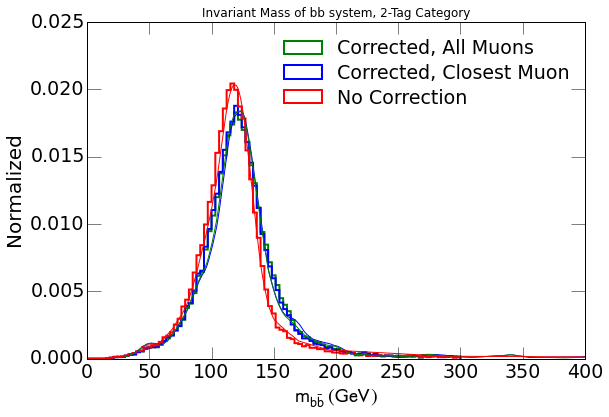

In [18]:
set_style('ATLAS', mpl=True)

hista = np.asarray(corrected_recomass)/1000
histb = np.asarray(onemuon_corrected_recomass)/1000
histc = np.asarray(recomass)/1000

a, bina, _ = plt.hist(hista, label = 'Corrected, All Muons', linewidth = 2,
           bins = np.linspace(0,300, 100), histtype = 'step', alpha = 1, color = 'green', normed = True)
b, binb, _ = plt.hist(histb, label = 'Corrected, Closest Muon', linewidth = 2,
           bins = np.linspace(0,300, 100), histtype = 'step', alpha = 1, color = 'blue', normed = True)
c, binc, _= plt.hist(histc, label = 'No Correction', linewidth = 2,
           bins = np.linspace(0,300, 100), histtype = 'step', alpha = 1, color = 'red', normed = True)

ixa = np.argsort(hista[:1000])
ixb = np.argsort(histb[:1000])
ixc = np.argsort(histc[:100])
log_dense_a = non_param_fit(hista[:1000])
log_dense_b = non_param_fit(histb[:1000])
log_dense_c = non_param_fit(histc[:1000])

plt.plot(hista[:1000][ixa], np.exp(log_dense_a)[ixa], '-',# label = 'Non-Parametric Fit CCM', 
         color = 'blue' )
plt.plot(histb[:1000][ixb], np.exp(log_dense_b)[ixb], '-',# label = 'Non-Parametric Fit CAM', 
         color = 'green' )
plt.plot(histc[:100][ixc], np.exp(log_dense_c)[ixc], '-',# label = 'Non-Parametric Fit NC', 
         color = 'red' )

plt.xlim(xmax=400)
plt.legend()
plt.ylabel('Normalized')
plt.xlabel(r'$m_{b\bar{b}}\ (\mathsf{GeV})$')
plt.title('Invariant Mass of bb system, 2-Tag Category')
plt.show()

In [19]:
print 'Peak for Corrected, All Muons = {}'.format(get_peak(hista, log_dense_a))
print 'Peak for Corrected, Closest Muon = {}'.format(get_peak(histb, log_dense_b))
print 'Peak for Non Corrected = {}'.format(get_peak(histc, log_dense_c))

Peak for Corrected, All Muons = 123.464262526
Peak for Corrected, Closest Muon = 123.00364893
Peak for Non Corrected = 118.450423813


## Count the number of Muons in Jets

In [20]:
print 'Number of events with 2 muons = {}'.format(len([len(event) for event in muon4vecs if len(event)==2]))
print 'Number of events with 1 muon = {}'.format(len([len(event) for event in muon4vecs if len(event)==1]))
print 'Number of events with 0 muon = {}'.format(len([len(event) for event in muon4vecs if len(event)==0]))

Number of events with 2 muons = 18080
Number of events with 1 muon = 41475
Number of events with 0 muon = 54725


### 1)  All jets in all events

In [22]:
# -- this is looking at ALL JETS IN ALL EVENTS, not just b-jets, and not just events with == 2 jets
tot = float(len(pup.flatten(NmuonsInJ)))

print 'Number of jets with > 5 muons = {}. Percentage = {}'.format(sum(pup.flatten(NmuonsInJ) > 5), 
                                                                 100*float(sum(pup.flatten (NmuonsInJ) > 5))/
                                                                 tot)

print 'Number of jets with 5 muons = {}. Percentage = {}'.format(sum(pup.flatten(NmuonsInJ)==5), 
                                                                 100*float(sum(pup.flatten (NmuonsInJ)==5))/
                                                                 tot)

print 'Number of jets with 4 muons = {}. Percentage = {}'.format(sum(pup.flatten(NmuonsInJ)==4),
                                                               100*float(sum(pup.flatten (NmuonsInJ)==4))/
                                                                 tot)

print 'Number of jets with 3 muons = {}. Percentage = {}'.format(sum(pup.flatten(NmuonsInJ)==3),
                                                               100*float(sum(pup.flatten (NmuonsInJ)==3))/
                                                                 tot)

print 'Number of jets with 2 muons = {}. Percentage = {}'.format(sum(pup.flatten(NmuonsInJ)==2), 
                                                                 100*float(sum(pup.flatten (NmuonsInJ)==2))/
                                                                 tot)

print 'Number of jets with 1 muon = {}. Percentage = {}'.format(sum(pup.flatten(NmuonsInJ)==1),
                                                               100*float(sum(pup.flatten (NmuonsInJ)==1))/
                                                                 tot)

print 'Number of jets with 0 muons = {}. Percentage = {}'.format(sum(pup.flatten(NmuonsInJ)==0),
                                                               100*float(sum(pup.flatten (NmuonsInJ)==0))/
                                                                 tot)

Number of jets with > 5 muons = 5. Percentage = 0.00126421611016
Number of jets with 5 muons = 32. Percentage = 0.00809098310502
Number of jets with 4 muons = 240. Percentage = 0.0606823732876
Number of jets with 3 muons = 1744. Percentage = 0.440958579223
Number of jets with 2 muons = 12415. Percentage = 3.13904860152
Number of jets with 1 muon = 72631. Percentage = 18.3642560594
Number of jets with 0 muons = 308435. Percentage = 77.9856991874


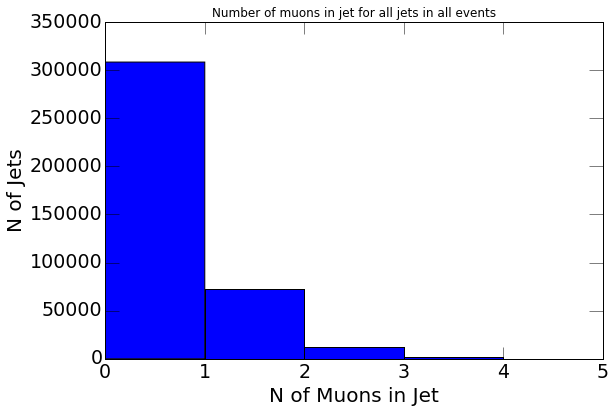

In [24]:
plt.hist(pup.flatten(NmuonsInJ), bins = np.linspace(0,5,6))
plt.ylabel('N of Jets')
plt.xlabel('N of Muons in Jet')
plt.title('Number of muons in jet for all jets in all events')
plt.show()

### 2) Only b-jets in all events

In [23]:
# -- this is looking only at b-tagged jets in all events, not just events with == 2 jets
tot = float(len(pup.flatten(NmuonsInJ)[pup.flatten(signal_df['HGamAntiKt4EMTopoJetsAuxDyn.MV2c20_85']) == 1]))

print 'Number of jets with > 5 muons = {}. Percentage = {}'.format(
    sum(pup.flatten(NmuonsInJ)[pup.flatten(signal_df['HGamAntiKt4EMTopoJetsAuxDyn.MV2c20_85']) == 1]>5), 
    100*float(sum(pup.flatten(NmuonsInJ)[pup.flatten(signal_df['HGamAntiKt4EMTopoJetsAuxDyn.MV2c20_85']) == 1]>5))/
    tot)

print 'Number of jets with 5 muons = {}. Percentage = {}'.format(
    sum(pup.flatten(NmuonsInJ)[pup.flatten(signal_df['HGamAntiKt4EMTopoJetsAuxDyn.MV2c20_85']) == 1]==5), 
    100*float(sum(pup.flatten(NmuonsInJ)[pup.flatten(signal_df['HGamAntiKt4EMTopoJetsAuxDyn.MV2c20_85']) == 1]==5))/
    tot)

print 'Number of jets with 4 muons = {}. Percentage = {}'.format(
    sum(pup.flatten(NmuonsInJ)[pup.flatten(signal_df['HGamAntiKt4EMTopoJetsAuxDyn.MV2c20_85']) == 1]==4), 
    100*float(sum(pup.flatten(NmuonsInJ)[pup.flatten(signal_df['HGamAntiKt4EMTopoJetsAuxDyn.MV2c20_85']) == 1]==4))/
    tot)

print 'Number of jets with 3 muons = {}. Percentage = {}'.format(
    sum(pup.flatten(NmuonsInJ)[pup.flatten(signal_df['HGamAntiKt4EMTopoJetsAuxDyn.MV2c20_85']) == 1]==3), 
    100*float(sum(pup.flatten(NmuonsInJ)[pup.flatten(signal_df['HGamAntiKt4EMTopoJetsAuxDyn.MV2c20_85']) == 1]==3))/
    tot)

print 'Number of jets with 2 muons = {}. Percentage = {}'.format(
    sum(pup.flatten(NmuonsInJ)[pup.flatten(signal_df['HGamAntiKt4EMTopoJetsAuxDyn.MV2c20_85']) == 1]==2), 
    100*float(sum(pup.flatten(NmuonsInJ)[pup.flatten(signal_df['HGamAntiKt4EMTopoJetsAuxDyn.MV2c20_85']) == 1]==2))/
    tot)

print 'Number of jets with 1 muon = {}. Percentage = {}'.format(
    sum(pup.flatten(NmuonsInJ)[pup.flatten(signal_df['HGamAntiKt4EMTopoJetsAuxDyn.MV2c20_85']) == 1]==1),
    100*float(sum(pup.flatten(NmuonsInJ)[pup.flatten(signal_df['HGamAntiKt4EMTopoJetsAuxDyn.MV2c20_85']) == 1]==1))/
    tot)

print 'Number of jets with 0 muon = {}. Percentage = {}'.format(
    sum(pup.flatten(NmuonsInJ)[pup.flatten(signal_df['HGamAntiKt4EMTopoJetsAuxDyn.MV2c20_85']) == 1]==0),
    100*float(sum(pup.flatten(NmuonsInJ)[pup.flatten(signal_df['HGamAntiKt4EMTopoJetsAuxDyn.MV2c20_85']) == 1]==0))/
    tot)


Number of jets with > 5 muons = 1. Percentage = 0.000637942253467
Number of jets with 5 muons = 12. Percentage = 0.00765530704161
Number of jets with 4 muons = 112. Percentage = 0.0714495323883
Number of jets with 3 muons = 962. Percentage = 0.613700447835
Number of jets with 2 muons = 7420. Percentage = 4.73353152073
Number of jets with 1 muon = 42895. Percentage = 27.3645329625
Number of jets with 0 muon = 105352. Percentage = 67.2084922873


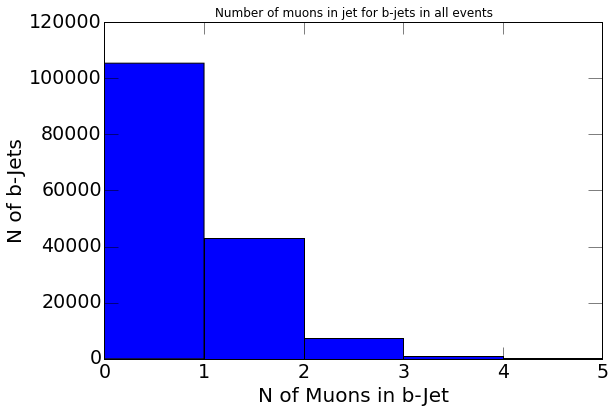

In [25]:
plt.hist(pup.flatten(NmuonsInJ)[pup.flatten(signal_df['HGamAntiKt4EMTopoJetsAuxDyn.MV2c20_85']) == 1], 
             bins = np.linspace(0,5,6))
plt.ylabel('N of b-Jets')
plt.xlabel('N of Muons in b-Jet')
plt.title('Number of muons in jet for b-jets in all events')
plt.show()

### 3) Only b-jets in events with == 2 b-jets

In [26]:
def select_b(event, truth):
    return np.array(event)[truth == 1].tolist()

d = [
        select_b(NmuonsInJ[ev], signal_df['HGamAntiKt4EMTopoJetsAuxDyn.MV2c20_85'].ix[ev])
        for ev in xrange(len(NmuonsInJ)) 
            if sum(signal_df['HGamAntiKt4EMTopoJetsAuxDyn.MV2c20_85'].ix[ev]) == 2
    ]

In [27]:
# -- this is looking only at b-tagged jets in all events, not just events with == 2 jets
print 'Number of jets with > 5 muons = {}. Percentage = {}'.format(
    sum(pup.flatten(d) > 5), 
    100*float(sum(pup.flatten(d) > 5))/
    float(len(pup.flatten(d))) )

print 'Number of jets with 5 muons = {}. Percentage = {}'.format(
    sum(pup.flatten(d) == 5), 
    100*float(sum(pup.flatten(d) == 5))/
    float(len(pup.flatten(d))) )

print 'Number of jets with 4 muons = {}. Percentage = {}'.format(
    sum(pup.flatten(d) == 4), 
    100*float(sum(pup.flatten(d) == 4))/
    float(len(pup.flatten(d))) )

print 'Number of jets with 3 muons = {}. Percentage = {}'.format(
    sum(pup.flatten(d) == 3), 
    100*float(sum(pup.flatten(d) == 3))/
    float(len(pup.flatten(d))) )

print 'Number of jets with 2 muons = {}. Percentage = {}'.format(
    sum(pup.flatten(d) == 2), 
    100*float(sum(pup.flatten(d) == 2))/
    float(len(pup.flatten(d))) )

print 'Number of jets with 1 muon = {}. Percentage = {}'.format(
    sum(pup.flatten(d) == 1), 
    100*float(sum(pup.flatten(d) == 1))/
    float(len(pup.flatten(d))) )

print 'Number of jets with 0 muon = {}. Percentage = {}'.format(
    sum(pup.flatten(d) == 0), 
    100*float(sum(pup.flatten(d) == 0))/
    float(len(pup.flatten(d))) )


Number of jets with > 5 muons = 0. Percentage = 0.0
Number of jets with 5 muons = 5. Percentage = 0.00551620661503
Number of jets with 4 muons = 50. Percentage = 0.0551620661503
Number of jets with 3 muons = 529. Percentage = 0.583614659871
Number of jets with 2 muons = 4049. Percentage = 4.46702411686
Number of jets with 1 muon = 24388. Percentage = 26.9058493855
Number of jets with 0 muon = 61621. Percentage = 67.982833565


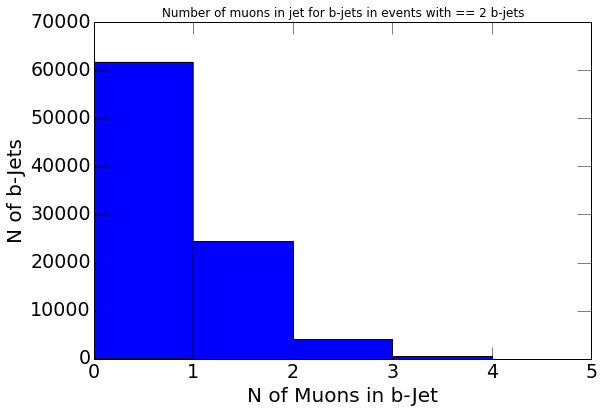

In [28]:
plt.hist(pup.flatten(d), bins = np.linspace(0,5,6))
plt.ylabel('N of b-Jets')
plt.xlabel('N of Muons in b-Jet')
plt.title('Number of muons in jet for b-jets in events with == 2 b-jets')
plt.show()

About 5% of jets have more than one muon in their correction. Therefore, we would expect the correction from all muons to be larger than the correction from one muon only. This would not be the case if the non-leading muons have very low pT or if they point in very different directions. 

### Check Difference in Mass Shift when correcting for ALL Muons VS. Closest Muon Only

In [88]:
# -- corrections from all muons for b-jets, for events with == 2 b-jets
mc2bb = [select_b(muons_corrections[ev], signal_df['HGamAntiKt4EMTopoJetsAuxDyn.MV2c20_85'].ix[ev])
 for ev in xrange(len(muons_corrections)) 
 if sum(signal_df['HGamAntiKt4EMTopoJetsAuxDyn.MV2c20_85'].ix[ev] == 1) == 2]

# -- corrections from the closest muon for b-jets, for events with == 2 b-jets
one_mc2bb = [select_b(onemuon_correction[ev], signal_df['HGamAntiKt4EMTopoJetsAuxDyn.MV2c20_85'].ix[ev])
 for ev in xrange(len(onemuon_correction)) 
 if sum(signal_df['HGamAntiKt4EMTopoJetsAuxDyn.MV2c20_85'].ix[ev] == 1) == 2]

In [108]:
# -- difference in m_bb if we correct for all muons vs only the closest one
mass_correction_difference = [np.asarray( ( (mc2bb[ev][0]+mc2bb[ev][1]-one_mc2bb[ev][0]-one_mc2bb[ev][1] ).M() ) )/1000 
          for ev in xrange(len(mc2bb))]

# Note: 
# This also includes 0 mass corrections for those events in which the jets had no muons in them

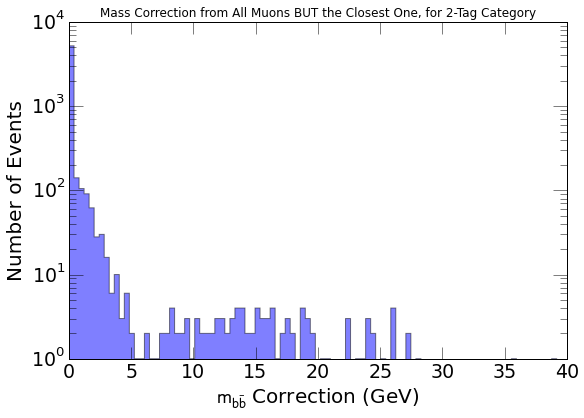

In [113]:
#plt.hist([np.asarray((mc2bb[ev][0]+mc2bb[ev][1]).M())/1000 for ev in xrange(len(mc2bb))], 
         #bins = np.linspace(0,100,100), histtype = 'stepfilled', alpha = 0.5, normed = True)
#plt.hist([np.asarray((one_mc2bb[ev][0]+one_mc2bb[ev][1]).M())/1000 for ev in xrange(len(one_mc2bb))], 
         #bins = np.linspace(0,100,100), histtype = 'stepfilled', alpha = 0.5, normed = True, color = 'red')
    
plt.hist( [mass_correction_difference[ev] for ev in xrange(len(mass_correction_difference)) 
                                                          if (mass_correction_difference[ev] != 0)], 
         bins = np.linspace(0,40,100), histtype = 'stepfilled', alpha = 0.5) #, normed = True)

plt.yscale('log')
plt.title('Mass Correction from All Muons BUT the Closest One, for 2-Tag Category')
plt.xlabel(r'$m_{b\bar{b}}$ Correction (GeV)')
plt.ylabel('Number of Events')
plt.show()

### Note: 
When plotting, I removed the events that have 0 mass correction due to the fact that the jets have no muons in them.
This would make the difference a bit unfair, because those events would show 0 difference between correcting for all
muons and correcting for the closest one only -- but this 0 difference wouldn't mean much given that there are no
muons at all. <br>
In general, though, one could make this plot considering the events with no muon correction at all, because they 
contribute to the idea that in most case correcting for one or all muons doesn't make much of a difference.

## Conclusion

From the last plot, we see that the difference in $m_{b\bar{b}}$ correction when we use all muons versus when we only use the closest muon is mostly very small, for the large majority of events. 

In [140]:
print 'Only {:.2f}% of events in the 2-Tag Category receive a correction > 5 GeV to m_bb when \
including all muons versus only the closest muon, even when we exclude all events in which there \
is no correction at all due to the complete absence of muons in jets.'.format(
    100*float(len([mass_correction_difference[ev] 
                   for ev in xrange(len(mass_correction_difference)) 
                        if (mass_correction_difference[ev] > 5)])) / 
        float(len([mass_correction_difference[ev] 
                   for ev in xrange(len(mass_correction_difference)) 
                        if (mass_correction_difference[ev] != 0)])))

Only 1.52% of events in the 2-Tag Category receive a correction > 5 GeV to m_bb when including all muons versus only the closest muon, even when we exclude all events in which there is no correction at all due to the complete absence of muons in jets.


### Old Stuff + Sandbox

In [105]:
def _dR(ev):
    if len(ev) < 2:
        return 99
    return deltaR(ev[0][1], ev[1][1], ev[0][2], ev[1][2])

dr_muons = [_dR(muon4vecs[event]) for event in xrange(len(muon4vecs))]    

In [142]:
# _ = plt.hist([muon4vecs[event][0][0]/1000 for event in xrange(len(muon4vecs)) if len(muon4vecs[event])==1], 
#             histtype = 'stepfilled', bins = np.linspace(0,60,100), alpha = 0.5, normed =True)   

# _ = plt.hist([muon4vecs[event][0][0]/1000 for event in xrange(len(muon4vecs)) if ((len(muon4vecs[event])==2) and (dr_muons[event] < 0.4))], 
#             histtype = 'stepfilled', bins = np.linspace(0,60,100), alpha = 0.5, color = 'red', normed = True)

#_ = plt.hist([muon4vecs[event][1][0]/1000 for event in xrange(len(muon4vecs)) if ((len(muon4vecs[event])==2) and (dr_muons[event] < 0.4))], 
           # histtype = 'stepfilled', bins = np.linspace(0,60,100), alpha = 0.5, color = 'green', normed = True)
#_ = plt.hist(
    #[ np.asarray(muon4vecs[event][0][0]+muon4vecs[event][1][0])/1000 for event in xrange(len(muon4vecs)) if ((len(muon4vecs[event])==2) and (dr_muons[event] < 0.4))], 
          #  histtype = 'stepfilled', bins = np.linspace(0,60,100), alpha = 0.5, color = 'green', normed = True)
#plt.show()